# Retrieval of a Methane High-Resolution Emission Spectrum

In this tutorial, we try to fit the ExoJAX emission model to a mock high-resolution spectrum. This spectrum was computed assuming a powerlaw temperature profile and CH4 opacity + CIA. 

In this tutorial, we use PreMODIT as an opacity calculator.

Note that the python file is available in tests/endtoend/reverse/reverse_premodit.ipynb 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from jax import random
import jax.numpy as jnp

import pandas as pd
import pkg_resources

from exojax.spec.atmrt import ArtEmisPure
from exojax.spec.api import MdbExomol
from exojax.spec.opacalc import OpaPremodit
from exojax.spec.contdb import CdbCIA
from exojax.spec.opacont import OpaCIA
from exojax.spec.response import ipgauss_sampling
from exojax.spec.spin_rotation import convolve_rigid_rotation
from exojax.spec import molinfo
from exojax.spec.unitconvert import nu2wav
from exojax.utils.grids import wavenumber_grid
from exojax.utils.grids import velocity_grid
from exojax.utils.astrofunc import gravity_jupiter
from exojax.utils.instfunc import resolution_to_gaussian_std
from exojax.test.data import SAMPLE_SPECTRA_CH4_NEW

We use numpyro as a probabilistic programming language (PPL). We have other options such as BlackJAX, PyMC etc.

In [ ]:
# PPL
import arviz
from numpyro.diagnostics import hpdi
from numpyro.infer import Predictive
from numpyro.infer import MCMC, NUTS
import numpyro
import numpyro.distributions as dist

Use FP64 just in case.

In [ ]:
from jax.config import config

config.update("jax_enable_x64", True)

We use a sample data of the methane emission spectrum in ExoJAX, normlized it, and add Gaussian noise.

In [ ]:
# loading the data
filename = pkg_resources.resource_filename(
    'exojax', 'data/testdata/' + SAMPLE_SPECTRA_CH4_NEW)
dat = pd.read_csv(filename, delimiter=",", names=("wavenumber", "flux"))
nusd = dat['wavenumber'].values
flux = dat['flux'].values
wavd = nu2wav(nusd)

sigmain = 0.05
norm = 20000
nflux = flux / norm + np.random.normal(0, sigmain, len(wavd))

We first set the wavenumber grid enough to cover the observed spectrum. Also, make "art" (Atmospheric Radiative Transfer) object. beta_inst is a STD of instrumental resolution. 

In [ ]:

Nx = 7500
nu_grid, wav, res = wavenumber_grid(np.min(wavd) - 10.0,
                                    np.max(wavd) + 10.0,
                                    Nx,
                                    unit='AA',
                                    xsmode='premodit')

Tlow = 400.0
Thigh = 1500.0
art = ArtEmisPure(nu_grid, pressure_top=1.e-8, pressure_btm=1.e2, nlayer=100)
art.change_temperature_range(Tlow, Thigh)
Mp = 33.2

Rinst = 100000.
beta_inst = resolution_to_gaussian_std(Rinst)

As usual, we make "mdb" and "opa" for CH4. Because CH4 has a lot of lines, we use PreMODIT as an opacity calculator. 

In [ ]:
### CH4 setting (PREMODIT)
mdb = MdbExomol('.database/CH4/12C-1H4/YT10to10/',
                nurange=nu_grid,
                gpu_transfer=False)
print('N=', len(mdb.nu_lines))
diffmode = 0
opa = OpaPremodit(mdb=mdb,
                  nu_grid=nu_grid,
                  diffmode=diffmode,
                  auto_trange=[Tlow, Thigh],
                  dit_grid_resolution=0.2)

As a continuum model, we assume CIA (H2 vs H2).

In [ ]:

## CIA setting
cdbH2H2 = CdbCIA('.database/H2-H2_2011.cia', nu_grid)
opcia = OpaCIA(cdb=cdbH2H2, nu_grid=nu_grid)
mmw = 2.33  # mean molecular weight
mmrH2 = 0.74
molmassH2 = molinfo.molmass_isotope('H2')
vmrH2 = (mmrH2 * mmw / molmassH2)  # VMR

Then, we make a function that computes the model spectrum.

In [ ]:

#settings before HMC
vsini_max = 100.0
vr_array = velocity_grid(res, vsini_max)

def frun(Tarr, MMR_CH4, Mp, Rp, u1, u2, RV, vsini):
    g = gravity_jupiter(Rp=Rp, Mp=Mp)  # gravity in the unit of Jupiter
    #molecule
    xsmatrix = opa.xsmatrix(Tarr, art.pressure)
    mmr_arr = art.constant_mmr_profile(MMR_CH4)
    dtaumCH4 = art.opacity_profile_lines(xsmatrix, mmr_arr, opa.mdb.molmass, g)
    #continuum
    logacia_matrix = opcia.logacia_matrix(Tarr)
    dtaucH2H2 = art.opacity_profile_cia(logacia_matrix, Tarr, vmrH2, vmrH2,
                                        mmw, g)
    #total tau
    dtau = dtaumCH4 + dtaucH2H2
    F0 = art.run(dtau, Tarr) / norm
    Frot = convolve_rigid_rotation(F0, vr_array, vsini, u1, u2)
    mu = ipgauss_sampling(nusd, nu_grid, Frot, beta_inst, RV, vr_array)
    return mu

The following is the numpyro model, i.e. prior and sample.

In [ ]:
def model_c(y1):
    Rp = numpyro.sample('Rp', dist.Uniform(0.4, 1.2))
    RV = numpyro.sample('RV', dist.Uniform(5.0, 15.0))
    MMR_CH4 = numpyro.sample('MMR_CH4', dist.Uniform(0.0, 0.015))
    T0 = numpyro.sample('T0', dist.Uniform(1000.0, 1500.0))
    alpha = numpyro.sample('alpha', dist.Uniform(0.05, 0.2))
    vsini = numpyro.sample('vsini', dist.Uniform(15.0, 25.0))
    u1 = 0.0
    u2 = 0.0
    Tarr = art.powerlaw_temperature(T0, alpha)
    mu = frun(Tarr, MMR_CH4, Mp, Rp, u1, u2, RV, vsini)
    numpyro.sample('y1', dist.Normal(mu, sigmain), obs=y1)

Let's run the HMC-NUTS. In my environment, it took 1.5 hours using A100.

In [ ]:
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)
num_warmup, num_samples = 500, 1000
#kernel = NUTS(model_c, forward_mode_differentiation=True)
kernel = NUTS(model_c, forward_mode_differentiation=False)

mcmc = MCMC(kernel, num_warmup=num_warmup, num_samples=num_samples)
mcmc.run(rng_key_, y1=nflux)
mcmc.print_summary()

Sampling...

In [ ]:
# SAMPLING
posterior_sample = mcmc.get_samples()
pred = Predictive(model_c, posterior_sample, return_sites=['y1'])
predictions = pred(rng_key_, y1=None)
median_mu1 = jnp.median(predictions['y1'], axis=0)
hpdi_mu1 = hpdi(predictions['y1'], 0.9)

O.K!, Plot the prediction!

In [ ]:
# PLOT
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 6.0))
ax.plot(wavd[::-1], median_mu1, color='C0')
ax.plot(wavd[::-1], nflux, '+', color='black', label='data')
ax.fill_between(wavd[::-1],
                hpdi_mu1[0],
                hpdi_mu1[1],
                alpha=0.3,
                interpolate=True,
                color='C0',
                label='90% area')
plt.xlabel('wavelength ($\AA$)', fontsize=16)
plt.legend(fontsize=16)
plt.tick_params(labelsize=16)
plt.savefig("pred_diffmode" + str(diffmode) + ".png")
plt.close()

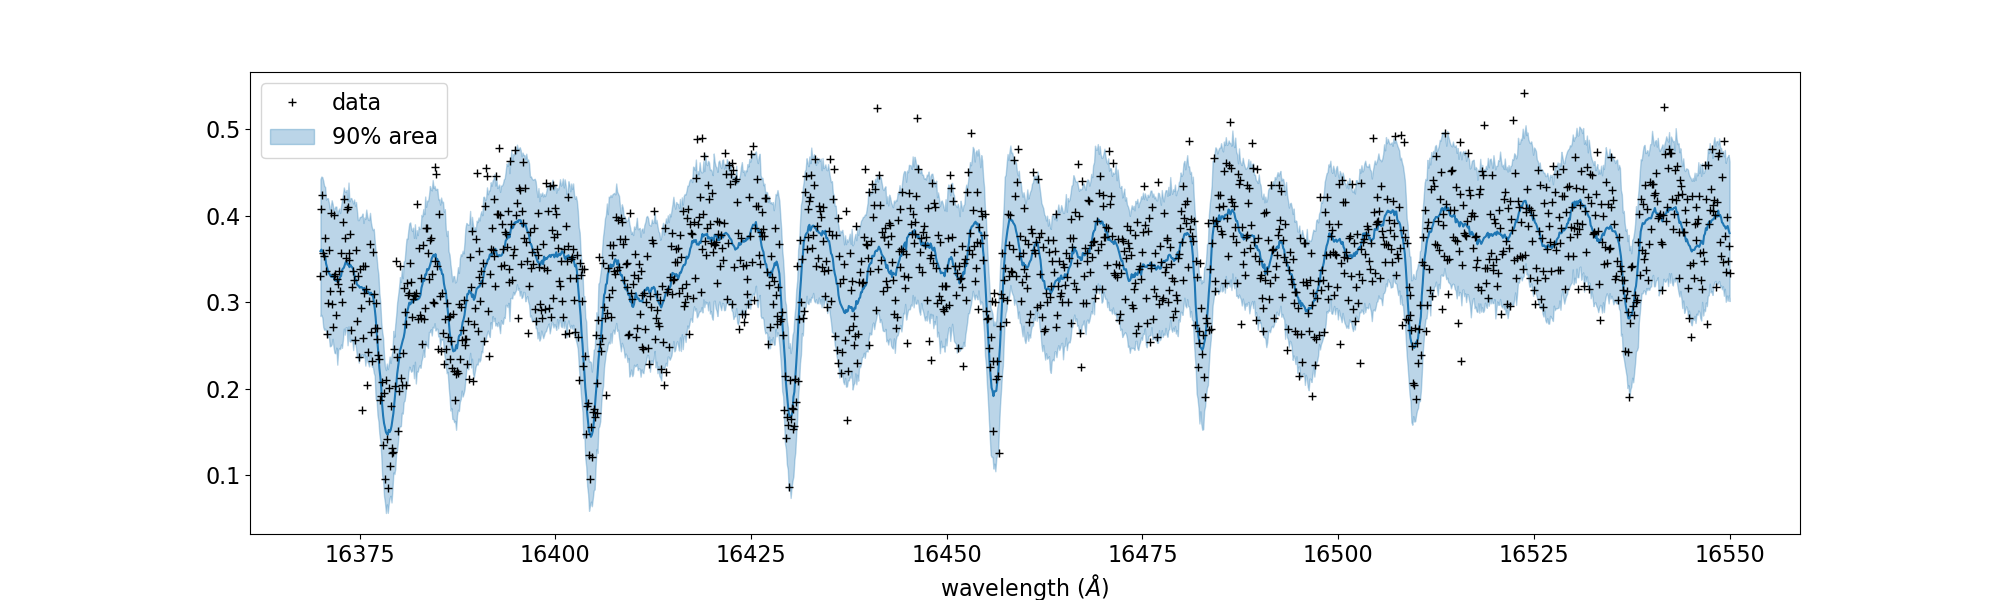

In [2]:
from IPython.display import Image
Image("pred_diffmode0.png")

Looks good. How about the contour plot?

In [ ]:

pararr = ['Rp', 'T0', 'alpha', 'MMR_CH4', 'vsini', 'RV']
arviz.plot_pair(arviz.from_numpyro(mcmc),
                kind='kde',
                divergences=False,
                marginals=True)
plt.savefig("corner_diffmode" + str(diffmode) + ".png")

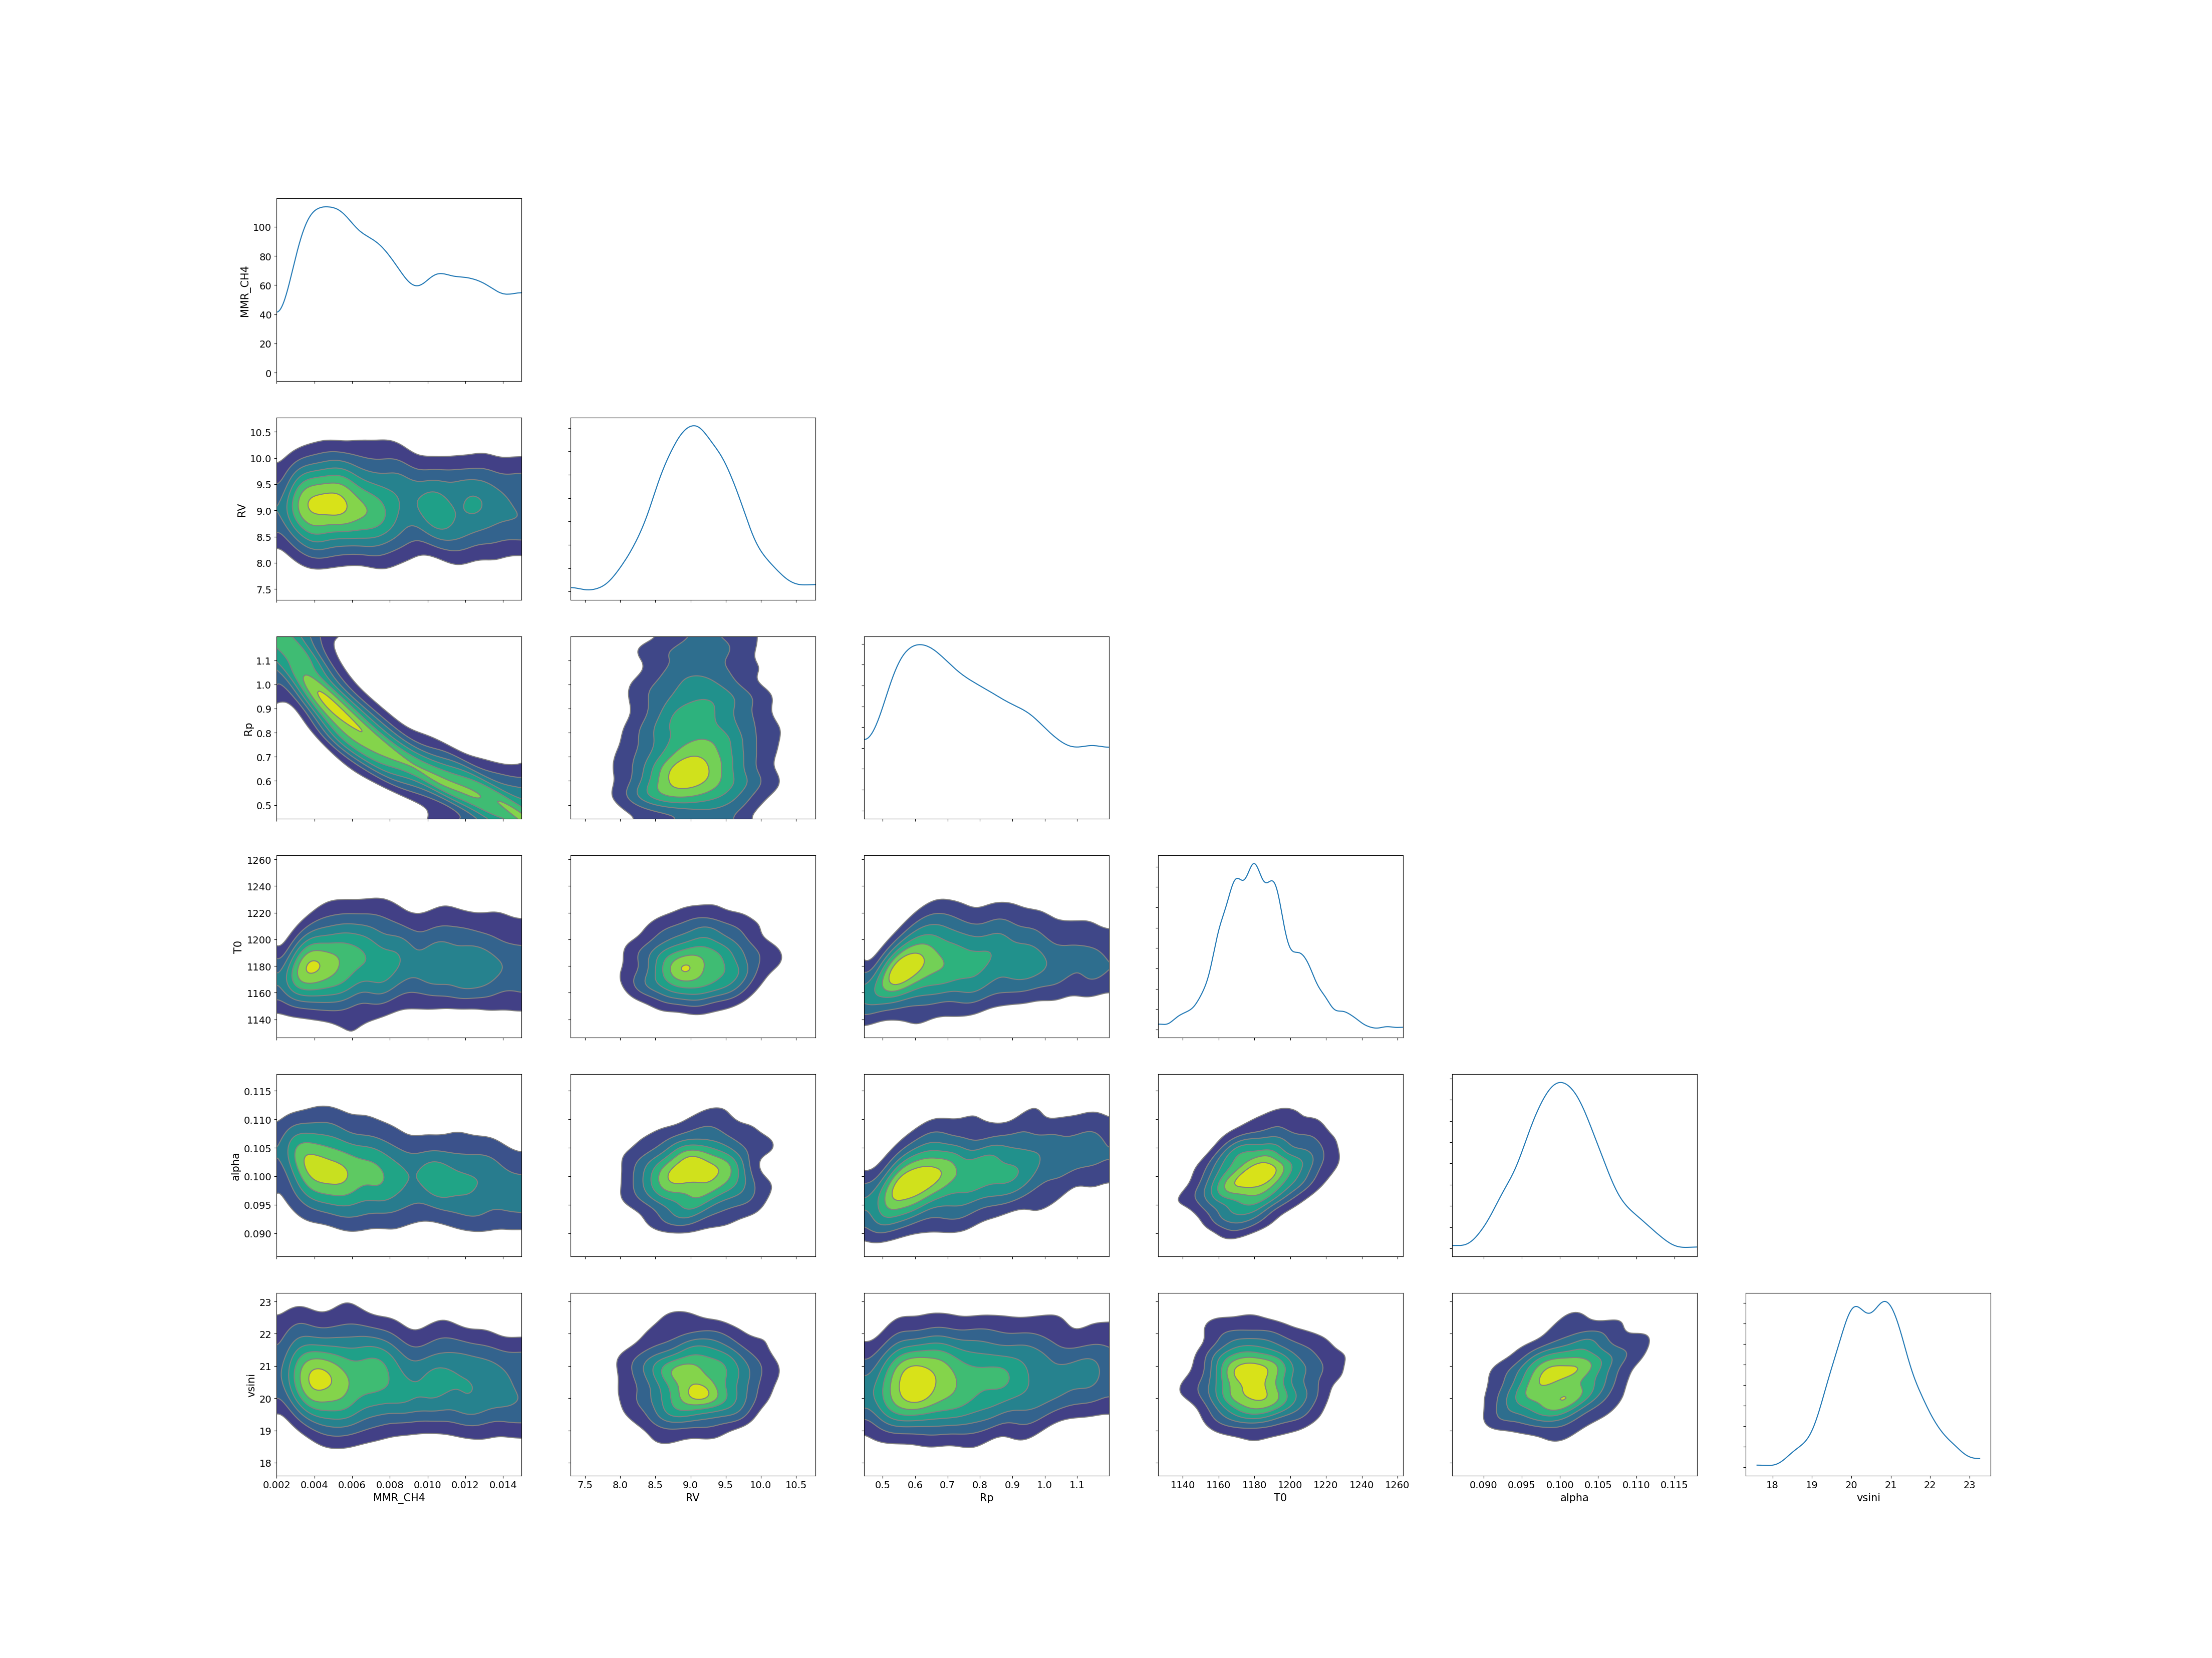

In [3]:
Image("corner_diffmode0.png")

That's it!